# Import Dataset

In [209]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import RFE
from Preprocessing_functions import *



In [210]:
train_data = pd.read_csv('train_data.csv', index_col='Claim Identifier')
test_data = pd.read_csv('test_data.csv', index_col='Claim Identifier')

/var/folders/z6/_vn8cndd4x5dmx2cpjfdkjdr0000gn/T/ipykernel_53674/3470921380.py:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('train_data.csv', index_col='Claim Identifier')


In [211]:
train_data.isna().sum()

Accident Date                          23134
Age at Injury                          19445
Alternative Dispute Resolution         19445
Assembly Date                              0
Attorney/Representative                19445
Average Weekly Wage                    48096
Birth Year                             48523
C-2 Date                               34005
C-3 Date                              406226
Carrier Name                           19445
Carrier Type                           19445
Claim Injury Type                      19445
County of Injury                       19445
COVID-19 Indicator                     19445
District Name                          19445
First Hearing Date                    442673
Gender                                 19445
IME-4 Count                           460668
Industry Code                          29403
Industry Code Description              29403
Medical Fee Region                     19445
OIICS Nature of Injury Description    593471
WCIO Cause

# Preprocessing

In [212]:
train_data = train_data[~(train_data.drop(columns=['Assembly Date']).isna().all(axis=1) & train_data['Assembly Date'].notna())]

In [213]:
X = train_data.drop(columns=['Claim Injury Type', 'WCB Decision', 'Agreement Reached'])
y = train_data['Claim Injury Type']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [214]:
y.isna().sum()

np.int64(0)

### column selection

In [215]:
CODE_COLUMNS = ['Industry Code', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code']

DESCRIPTION_COLUMNS = ['WCIO Cause of Injury Description','WCIO Nature of Injury Description','WCIO Part Of Body Description','Industry Code Description']

BOOLEAN_COLUMNS = ['Alternative Dispute Resolution', 'Attorney/Representative','COVID-19 Indicator']

date_order = ['Accident Date', 'C-2 Date','C-3 Date','Assembly Date', 'First Hearing Date']


In [216]:
numerical_columns = [
    'Accident Date', 
    'Age at Injury', 
    'Assembly Date', 
    'Average Weekly Wage', 
    'Birth Year', 
    'C-2 Date', 
    'C-3 Date', 
    'First Hearing Date', 
    'IME-4 Count', 
]

outliers_columns = [
    'Accident Date', 
    'Age at Injury', 
    'Assembly Date', 
    'Average Weekly Wage', 
    'Birth Year',
    'IME-4 Count', 
]

categorical_features = ['Alternative Dispute Resolution',
 'Attorney/Representative',
 'Carrier Name',
 'Carrier Type',
 'County of Injury',
 'COVID-19 Indicator',
 'District Name',
 'Gender',
 'Industry Code',
 'Medical Fee Region',
 'WCIO Cause of Injury Code',
 'WCIO Nature of Injury Code',
 'WCIO Part Of Body Code',
 'Zip Code']

col_minmax = ['Age at Injury',
               'Birth Year', 
               'Number of Dependents']

col_standart = ['Accident Date',
                'Assembly Date',
                'Average Weekly Wage',
                ]

columns_to_drop = ['C-2 Date', 'C-3 Date', 'First Hearing Date']

low_cardinality_cols = [col for col in categorical_features if X_train[col].nunique() < 10]
high_cardinality_cols = [col for col in categorical_features if X_train[col].nunique() > 10]




### Preprocesing testing

In [217]:
def type_coversion_categorical(X_train, X_val):
    X_train[categorical_features] = X_train[categorical_features].astype(str)
    X_val[categorical_features] = X_val[categorical_features].astype(str)
    return X_train, X_val

In [218]:
def drop_description_columns(X_train, X_val):
    """
    Drop all columns in X_train and X_val that contain the word 'description' in their names (case-insensitive).
    """
    description_columns = X_train.columns[X_train.columns.str.contains('description', case=False, na=False)]
    

    X_train = X_train.drop(description_columns, axis=1)
    X_val = X_val.drop(description_columns, axis=1)
    
    return X_train, X_val

In [219]:
def unwanted_columns(X_train, X_val, columns):
    X_train = X_train.drop(columns, axis=1)
    X_val = X_val.drop(columns, axis=1)
    return X_train, X_val

In [220]:
def winsorize_outliers(X_train, X_val, columns):
    """
    Winsorizes outliers in the specified columns for X_train and X_val.
    The bounds are calculated based on the X_train data.
    """
    for column in columns:
        # Calculate bounds based on X_train
        q1 = X_train[column].quantile(0.25)
        q3 = X_train[column].quantile(0.75)
        iqr = q3 - q1

        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Winsorize the column in X_train
        X_train[column] = X_train[column].apply(
            lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x)
        )

        # Winsorize the column in X_val using the same bounds
        X_val[column] = X_val[column].apply(
            lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x)
        )

    return X_train, X_val

In [221]:
def preprocessing_scaling_encoding_dum(X_train, X_val):
    X_train, X_val = type_coversion_categorical(X_train, X_val)
    X_train, X_val = drop_description_columns(X_train, X_val)
    X_train, X_val = convert_to_timestamp(X_train, X_val, date_order)
    X_train, X_val = convert_to_bool(X_train, X_val, col_names=BOOLEAN_COLUMNS)
    X_train, X_val = impute_mean_numerical(X_train, X_val, numerical_columns)
    X_train, X_val = fill_missing_with_mode(X_train, X_val)
    X_train, X_val = feature_creation_has_Cdate(X_train, X_val)
    X_train, X_val = unwanted_columns(X_train, X_val, columns_to_drop)
    X_train, X_val = winsorize_outliers(X_train, X_val, outliers_columns)
    X_train, X_val = scaling_minmax(X_train, X_val, col_minmax)
    X_train, X_val = scaling_standard(X_train, X_val, col_standart)
    X_train, X_val = encoding_onehot(X_train, X_val, low_cardinality_cols)
    X_train, X_val = encoding_frequency1(X_train, X_val, high_cardinality_cols)
    return X_train, X_val

X_train, X_val = preprocessing_scaling_encoding_dum(X_train, X_val)

y_train, y_val = encoding_label(y_train, y_val)

X_train.info()


/Users/philippedutranoit/document ordi/nova/machine learning /project/ML_Group36/src/Preprocessing_functions.py:330: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[col].fillna(mean_value, inplace=True)
/Users/philippedutranoit/document ordi/nova/machine learning /project/ML_Group36/src/Preprocessing_functions.py:331: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work 

<class 'pandas.core.frame.DataFrame'>
Index: 459220 entries, 5785935 to 6027959
Data columns (total 49 columns):
 #   Column                                                    Non-Null Count   Dtype  
---  ------                                                    --------------   -----  
 0   Accident Date                                             459220 non-null  float64
 1   Age at Injury                                             459220 non-null  float64
 2   Assembly Date                                             459220 non-null  float64
 3   Average Weekly Wage                                       459220 non-null  float64
 4   Birth Year                                                459220 non-null  float64
 5   IME-4 Count                                               459220 non-null  float64
 6   Number of Dependents                                      459220 non-null  float64
 7   Has C-3 Date                                              459220 non-null  int64  
 8   Ha

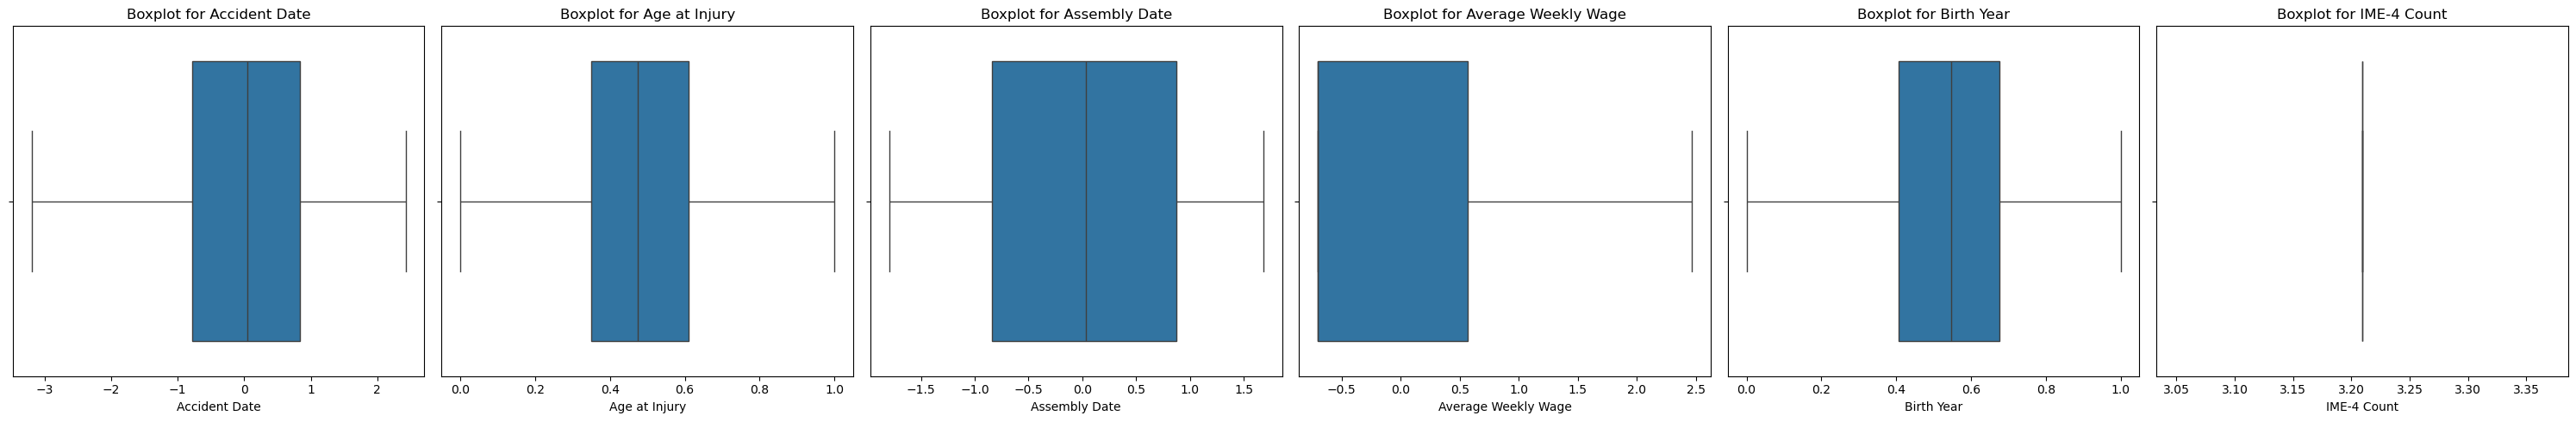

In [222]:
def plot_boxplots(df, columns):
    """
    Plots box plots for a list of columns in the given DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    columns (list): The list of column names to plot.

    Returns:
    None
    """
    num_columns = len(columns)
    fig, axes = plt.subplots(1, num_columns, figsize=(5 * num_columns, 5))

    # Ensure axes is iterable even for one column
    if num_columns == 1:
        axes = [axes]

    for ax, column in zip(axes, columns):
        sns.boxplot(data=df, x=column, ax=ax)
        ax.set_title(f'Boxplot for {column}')

    plt.tight_layout()
    plt.show()

# Example usage
plot_boxplots(X_train, outliers_columns)


In [223]:

"""
def preprocessing_complex(X_train, X_val):
    convert_to_timestamp(X_train, X_val, date_order)
    convert_to_bool(X_train, X_val, col_names=BOOLEAN_COLUMNS)
    impute_mean_numerical(X_train, X_val, ['C-2 Date'])
    fillna_zip_code(X_train, X_val)
    fillnan_accident_date(X_train,X_val)
    fillnan_birth_year(X_train,X_val)
    feature_creation_has_Cdate (X_train, X_val)
    fill_missing_with_mode(X_train, X_val)
    drop_description_columns(X_train, X_val)
    scaling_standard(X_train, X_val, columns)
    encoding_onehot(X_train, X_val, columns)
    return X_train, X_val
preprocessing_complex(X_train, X_val)

X_train.info()
"""

"\ndef preprocessing_complex(X_train, X_val):\n    convert_to_timestamp(X_train, X_val, date_order)\n    convert_to_bool(X_train, X_val, col_names=BOOLEAN_COLUMNS)\n    impute_mean_numerical(X_train, X_val, ['C-2 Date'])\n    fillna_zip_code(X_train, X_val)\n    fillnan_accident_date(X_train,X_val)\n    fillnan_birth_year(X_train,X_val)\n    feature_creation_has_Cdate (X_train, X_val)\n    fill_missing_with_mode(X_train, X_val)\n    drop_description_columns(X_train, X_val)\n    scaling_standard(X_train, X_val, columns)\n    encoding_onehot(X_train, X_val, columns)\n    return X_train, X_val\npreprocessing_complex(X_train, X_val)\n\nX_train.info()\n"

# Model Training

#### Perform a first RFE to select our best K

In [224]:
X_train_selected, selected_features, feature_ranking = feature_selection_rfe(X_train, y_train, 10, LogisticRegression(max_iter=1000))

KeyboardInterrupt: 

#### Run the model with the selected feature to find the best K

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, f1_score

k_range = range(1, 21)
f1_scores = []

best_k = None
best_f1_score = -np.inf

for k in k_range:
    model = KNeighborsClassifier(n_neighbors=k)
    
    f1_scorer = make_scorer(f1_score, average='macro')
    
    cv_scores = cross_val_score(model, X_train_selected, y_train, cv=5, scoring = f1_scorer)
    mean_f1_score = np.mean(cv_scores)
    f1_scores.append(mean_f1_score)
    
    if mean_f1_score > best_f1_score:
        best_f1_score = mean_f1_score
        best_k = k

# Print the best k value
print(f"The best k value is: {best_k}")
print(f"The best F1-score (macro) is: {best_f1_score}")

# Plot the F1 scores
plt.plot(k_range, f1_scores)
plt.xlabel('k value')
plt.ylabel('Cross-validated F1-score (macro)')
plt.title('KNN: Cross-Validation F1-Score (Macro) for Different k Values')
plt.show()


#### Run the model using K-fold and the K selected

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score

X = X.reset_index(drop=True) 
y = y.reset_index(drop=True)

k = best_k
n_splits = 5

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

accuracies = []
f1_scores = []

for train_index, val_index in kf.split(X_train):

    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    y_train, y_val = encoding_label(y_train, y_val)
    X_train, X_val = preprocessing_scaling_encoding_dum(X_train, X_val)

    X_train_selected, selected_features, feature_ranking = feature_selection_rfe(X_train, y_train, 10, LogisticRegression(max_iter=1000))

    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_selected, y_train)
    
    y_pred = model.predict(X_val[selected_features])
    
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='macro')
    
    accuracies.append(accuracy)
    f1_scores.append(f1)

mean_accuracy = np.mean(accuracies)
mean_f1_score = np.mean(f1_scores)

print(f"Average accuracy with k={k} across {n_splits}-fold cross-validation: {mean_accuracy}")
print(f"Average F1-score (macro) with k={k} across {n_splits}-fold cross-validation: {mean_f1_score}")

# Print the accuracy and F1-score matrix
print("\nAccuracy Matrix:")
for i in range(n_splits):
    print(f"Fold {i+1} - Accuracy: {accuracies[i]}, F1-score (macro): {f1_scores[i]}")



### running the full model(if time)

In [ ]:
X = X.reset_index(drop=True) 
y = y.reset_index(drop=True)


k_range = range(1, 10)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mean_f1_scores = []

# Cross-validation loop
for k in k_range:
    f1_scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]

        y_train, y_val = encoding_label(y_train, y_val)
        X_train, X_val = preprocessing_scaling_encoding_dum(X_train, X_val)

        X_train_selected, selected_features, feature_ranking = feature_selection_rfe(X_train, y_train, 10, LogisticRegression(max_iter=1000))

        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_selected, y_train)
        y_pred = knn.predict(X_val[selected_features])
        f1 = f1_score(y_val, y_pred, average='macro')
        f1_scores.append(f1)

    mean_f1_scores.append(np.mean(f1_scores))

optimal_k = k_range[np.argmax(mean_f1_scores)]
print(f"The optimal number of neighbors is {optimal_k}.")

plt.plot(k_range, mean_f1_scores)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean F1 Score')
plt.title('Optimal k Selection using K-Fold Cross-Validation')
plt.show()


X_preprocessed, _ = X_train, X_val = preprocessing_scaling_encoding_dum(X_train, X_val)
selector = RFE(estimator=LogisticRegression(solver='liblinear'), n_features_to_select=10)
X_final = selector.fit_transform(X_preprocessed, y)

final_knn = KNeighborsClassifier(n_neighbors=optimal_k)
final_knn.fit(X_final, y)

print(f"Model trained with optimal k={optimal_k}.")
  

/Users/philippedutranoit/document ordi/nova/machine learning /project/ML_Group36/src/Preprocessing_functions.py:330: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[col].fillna(mean_value, inplace=True)
/Users/philippedutranoit/document ordi/nova/machine learning /project/ML_Group36/src/Preprocessing_functions.py:331: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work 

KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Range of k values to test (for XGBoost, we can try different hyperparameters)
learning_rate_range = [0.01, 0.1, 0.3, 0.5, 0.7]
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# To store mean accuracy for each learning rate
mean_accuracies = []

# Perform K-Fold for each learning rate
for learning_rate in learning_rate_range:
    accuracies = []
    for train_index, test_index in kf.split(X):
        # Split the data into training and test sets for this fold
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train the XGBoost model
        model = XGBClassifier(learning_rate=learning_rate, use_label_encoder=False, eval_metric='mlogloss')
        model.fit(X_train, y_train)
        
        # Evaluate on the test set
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    
    # Compute the mean accuracy for this learning rate
    mean_accuracies.append(np.mean(accuracies))

# Find the optimal learning rate
optimal_lr = learning_rate_range[np.argmax(mean_accuracies)]
print(f"The optimal learning rate is {optimal_lr}.")

# Plot the results
plt.plot(learning_rate_range, mean_accuracies)
plt.xlabel('Learning Rate')
plt.ylabel('Mean Accuracy')
plt.title('Optimal Learning Rate Selection using K-Fold Cross-Validation (XGBoost)')
plt.show()

# Final training with optimal learning rate
final_model = XGBClassifier(learning_rate=optimal_lr, use_label_encoder=False, eval_metric='mlogloss')
final_model.fit(X, y)
print(f"Model trained with optimal learning rate={optimal_lr}.")
